# **Amazon Product Review Project**

### Binary Classification, Multiclass Classification & Clustering

Implementation of various ML models and utilizing the Amazon product review dataset to focus on binary classification, multi-class classification, and clustering approaches to analyze and categorize product reviews.

Abby Irish

Winter 2025

In [2]:
# load packages
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             confusion_matrix, make_scorer, adjusted_rand_score, 
                             silhouette_score)
import sklearn.metrics as metrics 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import label_binarize
from sklearn.metrics import silhouette_score, rand_score

In [3]:
# Load the datasets
train_df = pd.read_csv('/Users/abigailirish/Desktop/CS74/Training.csv')
test_df = pd.read_csv("/Users/abigailirish/Desktop/CS74/Test.csv")

train_df.head()
test_df.head()

,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,category
0,True,"07 23, 2015",28EA11D68FB7FF05B5ABB5989B0EDDD2,2CC19105CB9E7E4C30B1A399F3BFA181,B468F2974AA56619CF81B9DB66277892,ordered 318c and receive the 303c. my bad. i d...,Wrong filter,1437609600,NaN,NaN,NaN,automotive
1,True,"11 14, 2016",465EF4B95F3C23F3D2E0DF032806B593,44FF14695671384604654465F32F51BE,B9CBF62E157F0A8798A4D33BA089CE2B,slime must have a serious manufacturing defect...,Don't waste your time on the compressor lottery.,1479081600,6.0,NaN,NaN,automotive
2,True,"12 8, 2016",139CE33FEE21437434272524E638F60B,FD46962FBDA48B8BCB6BCCDE86515E83,68A0EDEBA61ACC7DD4096275BBFA6C8A,while the description says will not produce an...,Not error free in 2012 Mini Countryman S ALL4,1481155200,NaN,NaN,NaN,automotive
3,True,"06 16, 2016",5FAB0AEBEEF467F40843E12D1AD2176C,B602B679B1EDBD9C59BC91802E521324,5C6E597BBBCACE38B3335C3D02CB0522,"this keys could not start my truck, after cutt...","This keys could not start my truck, after cutt...",1466035200,NaN,NaN,{'Color:': ' Black'},automotive
4,False,"12 3, 2016",EEEFD48788F090F22767829BD219B24C,DA059E333E0AF68256582317DBEDA711,50DDC9EE6BA5B5E97F77CDC57CC32EFD,kept on trickle charger when the hd was not ri...,Kept on trickle charger when the HD was not ri...,1480723200,NaN,NaN,NaN,automotive


## **Part 1**: Binary Classification
#### Load the datasets and define the cutoff function

In [22]:
# define cutoff function
# learning models in scikit-learn expect numerical labels for classification

def assign_label(rating, cutoff):
    return 1 if rating > cutoff else 0

#### Feature extraction using 3 different methods

**Method 1:** TF-IDF

In [23]:
tfidf = TfidfVectorizer(min_df=10, max_df=0.4, sublinear_tf=False, use_idf=True)
X_train_tfidf = tfidf.fit_transform(train_df["reviewText"])

**Method 2:** CountVectorizer

In [24]:
count_vect = CountVectorizer()
X_train_count = count_vect.fit_transform(train_df["reviewText"])

**Method 3:** HashingVectorizer

In [25]:
hash_vectorizer = HashingVectorizer()
X_train_hash = hash_vectorizer.transform(train_df["reviewText"])

#### Function to evaluate models 
Reports confusion matrix, accuracy score, Macro F1 score, and ROC AUC for a passed in model

In [8]:
# function to evaluate model on the held-out validation set
def evaluate_model(y_true, y_pred, model_name):
    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    macro_f1 = metrics.f1_score(y_true, y_pred, average="macro")

    # Determine if binary or multi-class classification
    is_multiclass = len(set(y_true)) > 2

    # Compute ROC AUC Score
    roc_auc = None
    if is_multiclass:
        roc_auc = metrics.roc_auc_score(y_true, y_pred, average="macro", multi_class="ovo")
    else:
        roc_auc = metrics.roc_auc_score(y_true, y_pred)

    print(f"\n{model_name} Performance on Validation Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"ROC AUC: {roc_auc if roc_auc is not None else 'N/A'}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    metrics.ConfusionMatrixDisplay(conf_matrix).plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Plot ROC Curve if binary
    if not is_multiclass:
        fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color="red", label="ROC Curve")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random chance line
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc="lower right")
        plt.grid(linestyle="--")
        plt.show()

#### Function to tune hyperparameters with 5-fold cross-validation score
Chooses the best model using GridSearchCV function (defaulty uses 5-fold cross validation) which takes a parameter grid containing different ranges of hyperparameters depending on the type of classifier (Logistic Regression, SVM, and Naive Bayes) and determines the best combination of hyperparameters

In [9]:
# function to tune hyperparameters
def tune_model(X_train, y_train, X_val, y_val, vectorizer_name, model, param_grid):
    # define scoring metrics
    scoring = {
        "AUC": "roc_auc",
        "Accuracy": make_scorer(accuracy_score),
        "Macro F1": make_scorer(f1_score, average="macro")
    }
    
    # function to search for best combination of hyperparameters
    gs = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring=scoring,
        refit="Macro F1",
        n_jobs=-1,
        return_train_score=True,
    )
    gs.fit(X_train, y_train)

    # fit the model with best combination
    best_model = gs.best_estimator_
    best_model.fit(X_train, y_train)

    # predict labels using best model
    y_val_pred = best_model.predict(X_val)

    # report metrics
    print(f"\nBest Hyperparameters for {vectorizer_name}: {gs.best_params_}")
    print(f"Best Macro F1 Score: {gs.best_score_:.4f}")
    evaluate_model(y_val, y_val_pred, f"{model.__class__.__name__} ({vectorizer_name})")

    return best_model

### **Cutoff = 1**

In [362]:
# apply a cutoff of 1
train_df["label_cutoff_1"] = train_df["overall"].apply(lambda x: assign_label(x, cutoff=1))
train_df.head() # inspect
y_train_cutoff1 = train_df["label_cutoff_1"]

#### **Logistic Regression**

326346.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326346.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326346.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326346.56s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326346.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326346.60s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326346.61s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326346.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debuggi


Best Hyperparameters for TF-IDF: {'C': 0.75, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Macro F1 Score: 0.7318

LogisticRegression (TF-IDF) Performance on Validation Set:
Accuracy: 0.7982
Macro F1 Score: 0.7382
ROC AUC: 0.7827173996317343


<Figure size 600x500 with 0 Axes>

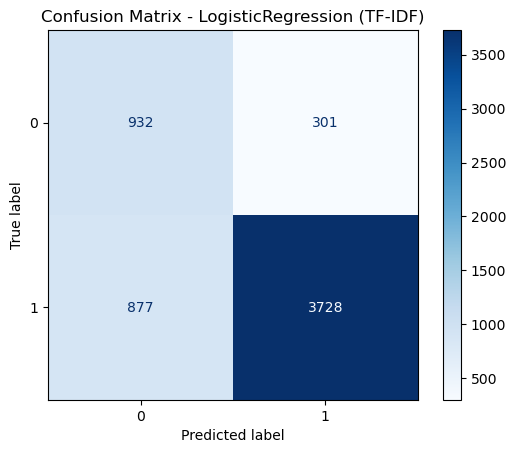

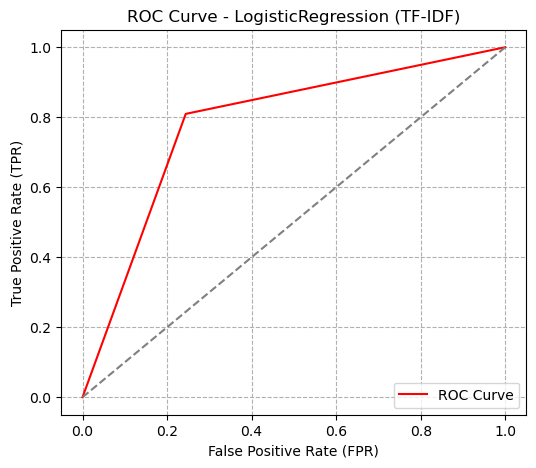

LogisticRegression(C=0.75, class_weight='balanced', max_iter=5000)

In [363]:
# tune LR (tfidf) hyperparameters
lr_param_grid = {
    "C": [0.01, 0.1, 0.5, .75, 1, 1.25, 1.5, 2, 5],  
    "penalty": ["l2"],  
    "solver": ["lbfgs", "saga"]
}

# report of one validation set (20% of data)
X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff1, test_size=0.2, random_state=42)

# tune the model and report metrics
tune_model(X_train_tfidf_sub, y_train_sub, X_val_tfidf, y_val, "TF-IDF", 
           LogisticRegression(max_iter=5000, class_weight="balanced"), 
           lr_param_grid)


Best Hyperparameters for CountVectorizer: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best Macro F1 Score: 0.7054

LogisticRegression (CountVectorizer) Performance on Validation Set:
Accuracy: 0.8356
Macro F1 Score: 0.7207
ROC AUC: 0.6980051831950356


<Figure size 600x500 with 0 Axes>

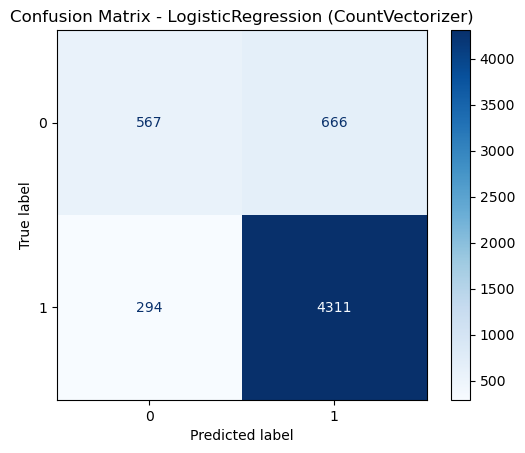

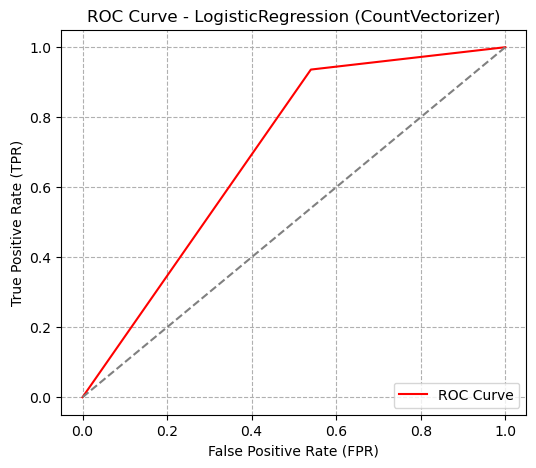

In [93]:
# tune LR hyperparameters
lr_param_grid = {
    "C": [0.1, 1, 10],  
    "penalty": ["l2"],  
    "solver": ["lbfgs", "saga"]
}

# report of one validation set (20% of data)
X_train_count_sub, X_val_count, y_train_sub, y_val = train_test_split(
    X_train_count, y_train_cutoff1, test_size=0.2, random_state=42)

# tune the model and report metrics
tune_model(X_train_count_sub, y_train_sub, X_val_count, y_val, 
           "CountVectorizer", 
           LogisticRegression(max_iter=5000, class_weight="balanced"), 
           lr_param_grid)

326411.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326412.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326412.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326412.02s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326412.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326412.05s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326412.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
326412.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debuggi


Best Hyperparameters for HashingVectorizer: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best Macro F1 Score: 0.7290

LogisticRegression (HashingVectorizer) Performance on Validation Set:
Accuracy: 0.8082
Macro F1 Score: 0.7438
ROC AUC: 0.7783251569884634


<Figure size 600x500 with 0 Axes>

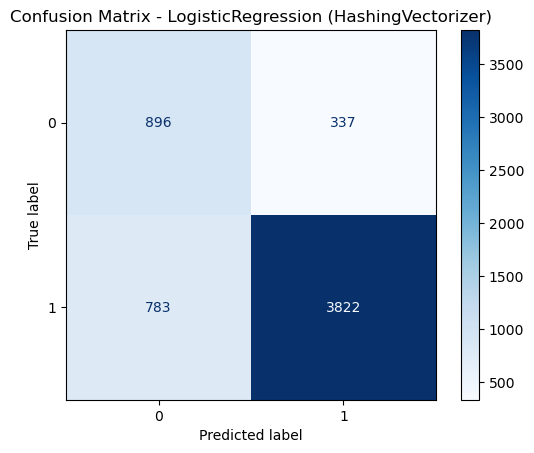

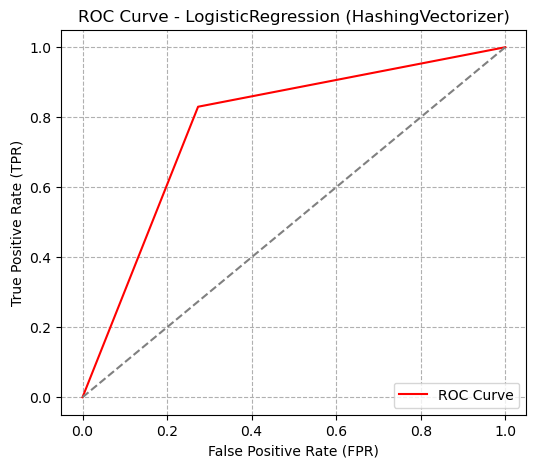

In [365]:
# tune HashingVectorizer LR hyperparameters
lr_param_grid = {
    "C": [0.05, 0.1, 0.5, 1, 1.5, 5, 10, 11, 15, 16, 20],  
    "penalty": ["l2"],  
    "solver": ["saga"]
}
# report on one validation set (20% of data)
X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff1, test_size=0.2, random_state=42)

# tune the model and report metrics
best_model = tune_model(X_train_hash_sub, y_train_sub, X_val_hash, y_val, 
                        "HashingVectorizer", 
                        LogisticRegression(max_iter=5000, class_weight="balanced"), 
                        lr_param_grid)

Logistic Regression cutoff = 1 best model: HashingVectorizer LR model

hyperparameters: C = 10, penalty = l2, solver = saga

#### **Support Vector Machine**

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i


Best Hyperparameters for TF-IDF: {'C': 1, 'kernel': 'linear'}
Best Macro F1 Score: 0.6247

SVC (TF-IDF) Performance on Validation Set:
Accuracy: 0.7232
Macro F1 Score: 0.6121
ROC AUC: 0.6214333832631938


<Figure size 600x500 with 0 Axes>

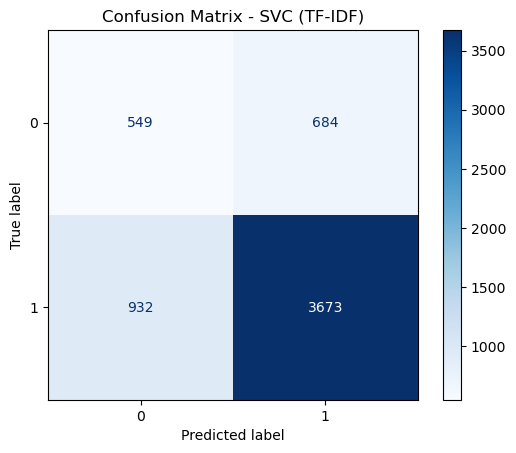

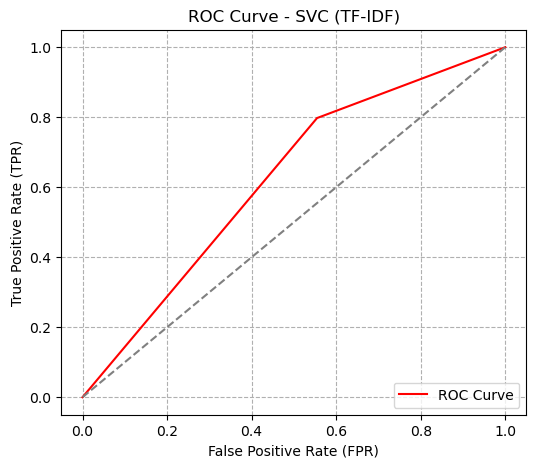

In [115]:
# SVM tfidf
svm_param_grid = {
    "C": [.01, .1, 1, 2],  # Regularization strength
    "kernel": ["linear"],  # linear kernel for text data
}

# report on one validation set (20% of data)
X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff1, test_size=0.2, random_state=42)

# tune and report metrics
tune_model(X_train_tfidf_sub, y_train_sub, X_val_tfidf, y_val, 
           "TF-IDF", 
           SVC(max_iter=1000), 
           svm_param_grid)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i


Best Hyperparameters for HashingVectorizer: {'C': 1, 'kernel': 'linear'}
Best Macro F1 Score: 0.5754

SVC (HashingVectorizer) Performance on Validation Set:
Accuracy: 0.7162
Macro F1 Score: 0.5770
ROC AUC: 0.5774890299605581


<Figure size 600x500 with 0 Axes>

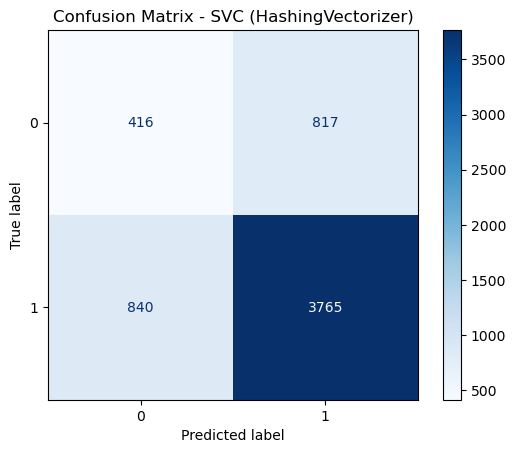

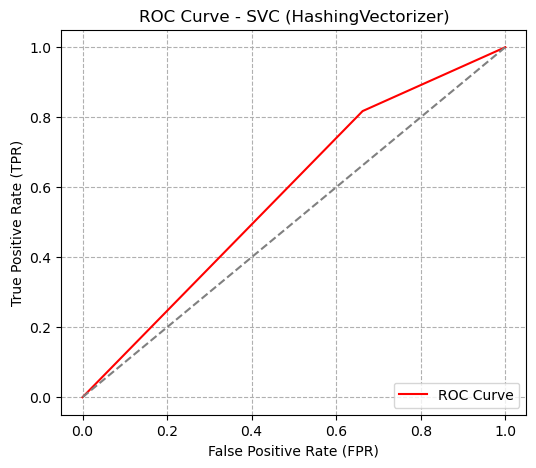

In [117]:
# SVM HashingVectorizer
# report on one validation set (20% of data)
X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff1, test_size=0.2, random_state=42)

# tune and report metrics
tune_model(X_train_hash_sub, y_train_sub, X_val_hash, y_val, 
           "HashingVectorizer", 
           SVC(max_iter=1000), 
           svm_param_grid)

#### **Naive Bayes Classifier**


Best Hyperparameters for TF-IDF: {'alpha': 0.01}
Best Macro F1 Score: 0.5684

MultinomialNB (TF-IDF) Performance on Validation Set:
Accuracy: 0.8135
Macro F1 Score: 0.5730
ROC AUC: 0.5702716554258436


<Figure size 600x500 with 0 Axes>

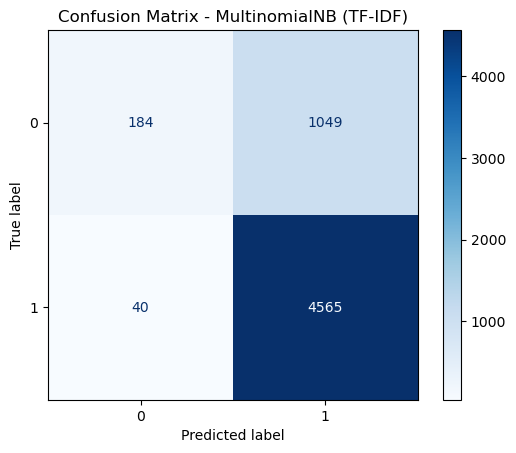

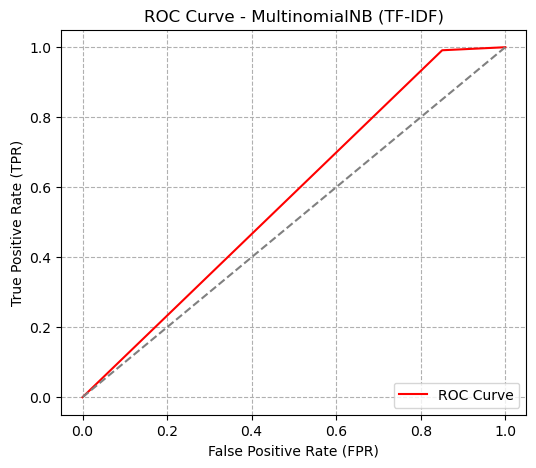

MultinomialNB(alpha=0.01)

In [377]:
# evaluate Naive Bayes tfidf 
NB_param_grid = {
    "alpha": [.01, .1, 1, 5, 10]
}

# report on one validation set (20% of data)
X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff1, test_size=0.2, random_state=42)

# tune and report metrics
tune_model(X_train_tfidf_sub, y_train_sub, X_val_tfidf, y_val, 
           "TF-IDF", 
           MultinomialNB(), 
           NB_param_grid)


Best Hyperparameters for HashingVectorizer: {'alpha': 0.01}
Best Macro F1 Score: 0.5022

MultinomialNB (HashingVectorizer) Performance on Validation Set:
Accuracy: 0.7999
Macro F1 Score: 0.5058
ROC AUC: 0.5317033479424407


<Figure size 600x500 with 0 Axes>

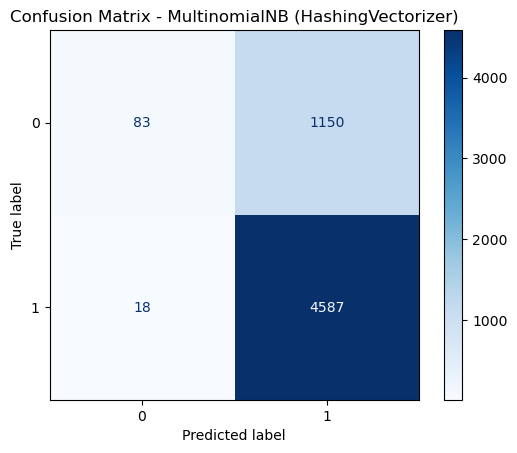

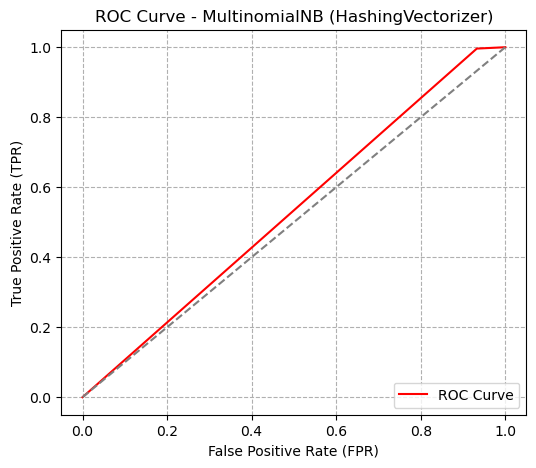

MultinomialNB(alpha=0.01)

In [378]:
# evaluate Naive Bayes hashing
# Use non-negative HashingVectorizer
hash_false = HashingVectorizer(n_features=2**16, alternate_sign=False)
X_train_hash = hash_false.transform(train_df["reviewText"])
X_test_hash = hash_false.transform(test_df["reviewText"])

# report on one validation set (20% of data)
X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff1, test_size=0.2, random_state=42)

# tune and report metrics
tune_model(X_train_hash_sub, y_train_sub, X_val_hash, y_val, 
           "HashingVectorizer", 
           MultinomialNB(), 
           NB_param_grid)

##### Cutoff 1 best model: Logistic Regression (with Hashing Vectorizer feature extraction method)

Save as csv to run on test dataset in kaggle:

In [140]:
# Transform test reviews using the best-performing feature extraction method
X_test_hash = hash_vectorizer.transform(test_df["reviewText"])  # LR Hash was best

# Use the trained model to predict
y_pred_hash = best_model.predict(X_test_hash)

# Format predictions for submission
test_ids = test_df.index
test_submission = pd.DataFrame({'id': test_ids, 'binary_split_1': y_pred_hash})
print(test_submission.shape) # should be (4500, 2)
test_submission.head()

# Save the predictions file
test_submission.to_csv("test_submission_part_1.csv", index=False)
print("Submission file saved: test_submission_part_1.csv")

(4500, 2)
Submission file saved: test_submission_part_1.csv


Cutoff = 1 Macro F1 score on test set in Kaggle: **0.72570**

#### **Cutoff = 2**

In [201]:
train_df["label_cutoff_2"] = train_df["overall"].apply(lambda x: assign_label(x, cutoff=2))
train_df.head() # inspect
y_train_cutoff2 = train_df["label_cutoff_2"]

#### **Logistic Regression:**


Best Hyperparameters for TF-IDF (Standardized): {'C': 0.25, 'penalty': 'l2', 'solver': 'saga'}
Best Macro F1 Score: 0.7818

LogisticRegression (TF-IDF (Standardized)) Performance on Validation Set:
Accuracy: 0.7912
Macro F1 Score: 0.7867
ROC AUC: 0.7913370080877236


<Figure size 600x500 with 0 Axes>

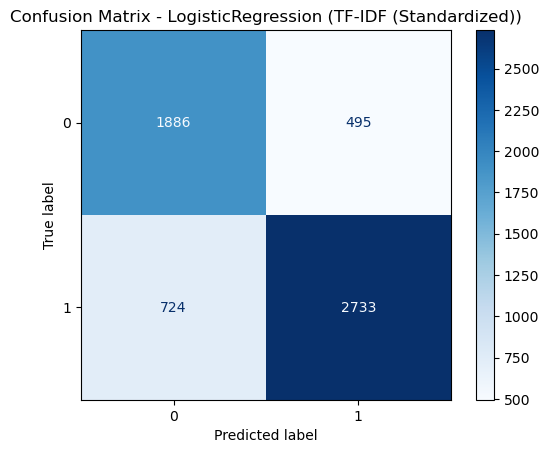

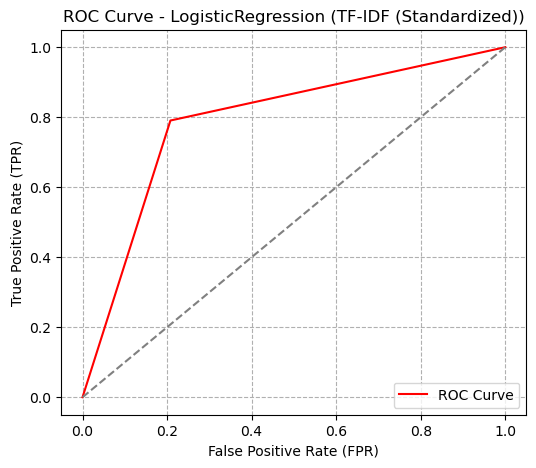

In [252]:
# tune tfidf LR hyperparameters
lr_param_grid = {
    "C": [0.1, 0.25, 0.5, .75, 1, 2, 5],  
    "penalty": ["l2"],  
    "solver": ["saga"]
}

# report on one validation set (20%)
X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff2, test_size=0.2, random_state=42)

# scale data to ensure features contribute equal weight
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf_sub)
X_val_scaled = scaler.transform(X_val_tfidf)

# tune and report metrics
best_model = tune_model(X_train_scaled, y_train_sub, X_val_scaled, y_val, 
           "TF-IDF (Standardized)", 
           LogisticRegression(max_iter=5000, class_weight="balanced"),
           lr_param_grid)


Best Hyperparameters for HashingVectorizer: {'C': 4.5, 'penalty': 'l2', 'solver': 'saga'}
Best Macro F1 Score: 0.7825

LogisticRegression (HashingVectorizer) Performance on Validation Set:
Accuracy: 0.7859
Macro F1 Score: 0.7814
ROC AUC: 0.7861343727710346


<Figure size 600x500 with 0 Axes>

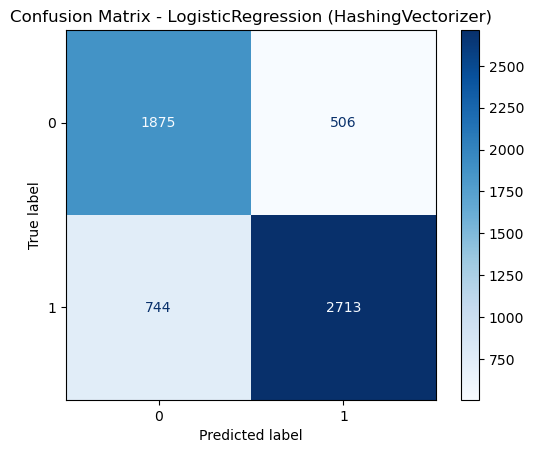

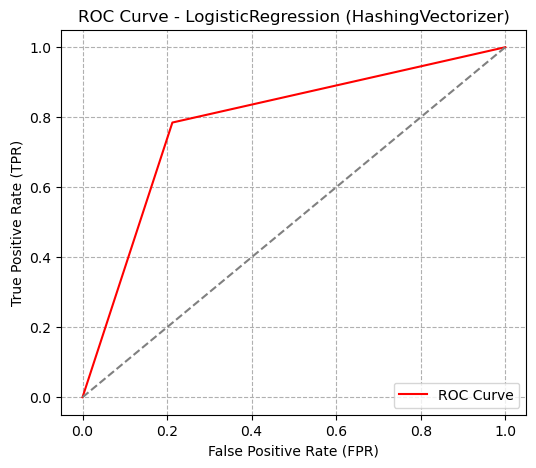

LogisticRegression(C=4.5, class_weight='balanced', max_iter=5000, solver='saga')

In [251]:
# tune hash LR hyperparameters
lr_param_grid = {
    "C": [3, 4, 4.5, 5, 5.5, 6],  
    "penalty": ["l2"],  
    "solver": ["saga"]
}

# report on one validation set (20%)
X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff2, test_size=0.2, random_state=42)

# tune and report metrics
tune_model(X_train_hash_sub, y_train_sub, X_val_hash, y_val, 
           "HashingVectorizer", 
           LogisticRegression(max_iter=5000, class_weight="balanced"), 
           lr_param_grid)

#### **Support-Vector Machine:**

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i


Best Hyperparameters for TF-IDF (Standardized): {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
Best Macro F1 Score: 0.6461

SVC (TF-IDF (Standardized)) Performance on Validation Set:
Accuracy: 0.6220
Macro F1 Score: 0.6148
ROC AUC: 0.6177838925142238


<Figure size 600x500 with 0 Axes>

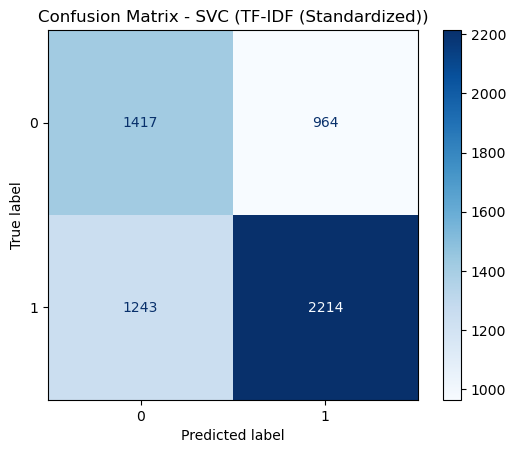

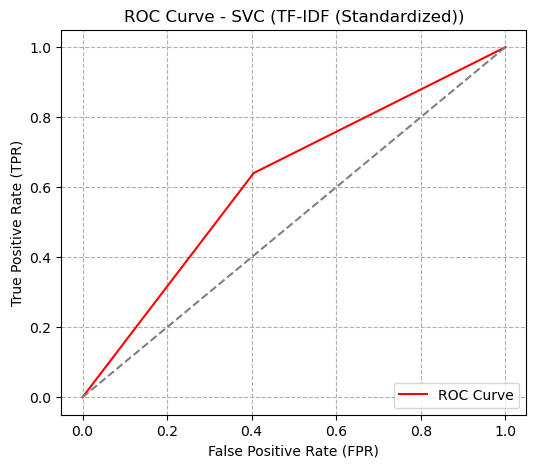

SVC(C=1, gamma='auto', kernel='linear', max_iter=1000)

In [212]:
# tdidf
svm_param_grid = {
    "C": [.01, .1, .5, 1, 1.5],  # Regularization strength
    "kernel": ["linear"],  # Linear kernel for text data
    "gamma": ["auto"]
}

# report on one validation set (20%)
X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff2, test_size=0.2, random_state=42)

# scale data to ensure that all features contribute equally 
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf_sub)
X_val_scaled = scaler.transform(X_val_tfidf)

# tune and report metrics
tune_model(X_train_scaled, y_train_sub, X_val_scaled, y_val, 
           "TF-IDF (Standardized)", 
           SVC(max_iter=1000),
           svm_param_grid)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i


Best Hyperparameters for HashingVectorizer (Standardized): {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
Best Macro F1 Score: 0.6425

SVC (HashingVectorizer (Standardized)) Performance on Validation Set:
Accuracy: 0.6603
Macro F1 Score: 0.6388
ROC AUC: 0.636978857183053


<Figure size 600x500 with 0 Axes>

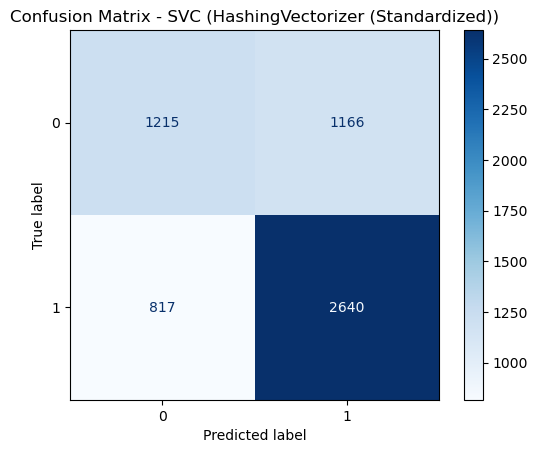

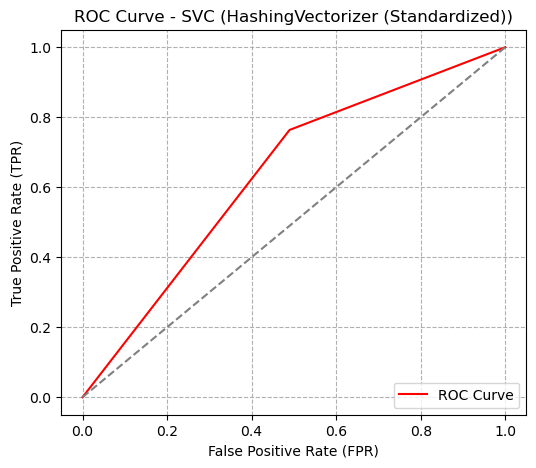

SVC(C=1, gamma='auto', kernel='linear', max_iter=1000)

In [213]:
# SVM Hashing Vectorizer
X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff2, test_size=0.2, random_state=42)

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_hash_sub)
X_val_scaled = scaler.transform(X_val_hash)

# Train & tune SVM with Scaled Features
tune_model(X_train_scaled, y_train_sub, X_val_scaled, y_val, 
           "HashingVectorizer (Standardized)", 
           SVC(max_iter=1000),
           svm_param_grid)

#### **Naive Bayes:**


Best Hyperparameters for TF-IDF: {'alpha': 0.3}
Best Macro F1 Score: 0.7368

MultinomialNB (TF-IDF) Performance on Validation Set:
Accuracy: 0.7682
Macro F1 Score: 0.7453
ROC AUC: 0.738033307022607


<Figure size 600x500 with 0 Axes>

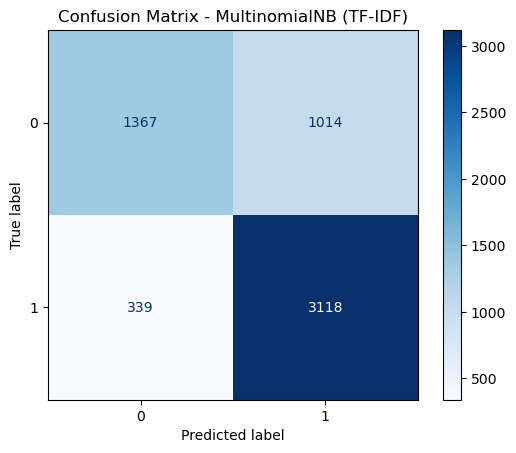

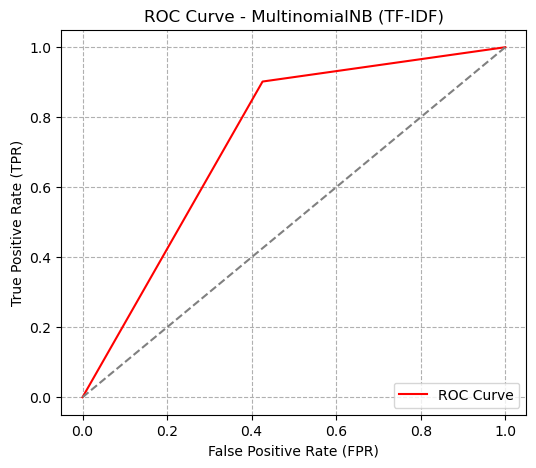

MultinomialNB(alpha=0.3)

In [239]:
# evaluate Naive Bayes tfidf 
NB_param_grid = {
    "alpha": [0.05, 0.08, 0.1, 0.15, 0.3, 0.5]
}

X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff2, test_size=0.2, random_state=42)

tune_model(X_train_tfidf_sub, y_train_sub, X_val_tfidf, y_val, 
           "TF-IDF", 
           MultinomialNB(), 
           NB_param_grid)


Best Hyperparameters for HashingVectorizer: {'alpha': 0.05}
Best Macro F1 Score: 0.7058

MultinomialNB (HashingVectorizer) Performance on Validation Set:
Accuracy: 0.7552
Macro F1 Score: 0.7198
ROC AUC: 0.713968772403551


<Figure size 600x500 with 0 Axes>

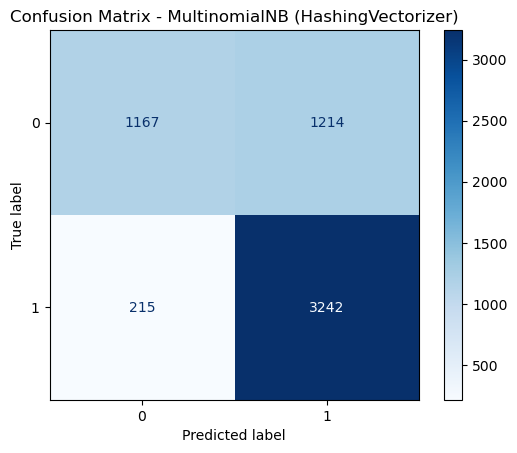

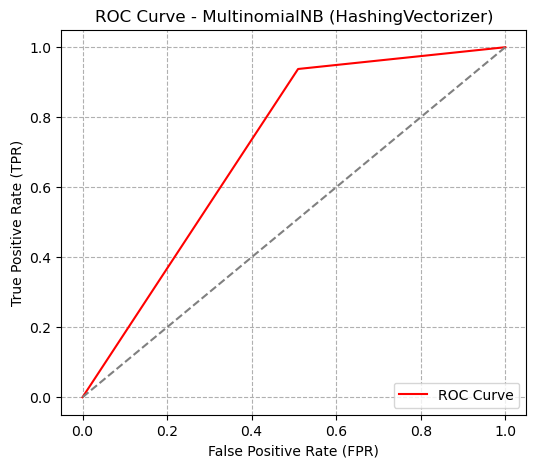

MultinomialNB(alpha=0.05)

In [234]:
# evaluate Naive Bayes hashing
# Use non-negative HashingVectorizer
hash_false = HashingVectorizer(n_features=2**16, alternate_sign=False)
X_train_hash = hash_false.transform(train_df["reviewText"])
X_test_hash = hash_false.transform(test_df["reviewText"])

X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff2, test_size=0.2, random_state=42)

tune_model(X_train_hash_sub, y_train_sub, X_val_hash, y_val, 
           "HashingVectorizer", 
           MultinomialNB(), 
           NB_param_grid)

##### Cutoff 2 best model: Logistic Regression (tfidf)

Save as csv to run on test dataset in kaggle:

In [254]:
# Transform test reviews using the best-performing feature extraction method
X_test_tfidf = tfidf.transform(test_df["reviewText"])  # LR tfidf was the best

# Use the trained model to predict
y_pred_tfidf = best_model.predict(X_test_tfidf)

# Format predictions for submission
test_ids = test_df.index
test_submission = pd.DataFrame({'id': test_ids, 'binary_split_2': y_pred_tfidf})
print(test_submission.shape) # should be (4500, 2)
test_submission.head()

# # Save the predictions file
test_submission.to_csv("test_submission_part_2.csv", index=False)

print("Submission file saved: test_submission_part_2.csv")

(4500, 2)
Submission file saved: test_submission_part_2.csv


Cutoff = 2 Macro F1 score on test set in Kaggle: **0.78212**

### **Cutoff = 3**

In [312]:
train_df["label_cutoff_3"] = train_df["overall"].apply(lambda x: assign_label(x, cutoff=3))
train_df.head() # inspect
y_train_cutoff3 = train_df["label_cutoff_3"]

#### **Logistic Regression**


Best Hyperparameters for TF-IDF (Standardized): {'C': 0.6, 'penalty': 'l2', 'solver': 'saga'}
Best Macro F1 Score: 0.8106

LogisticRegression (TF-IDF (Standardized)) Performance on Validation Set:
Accuracy: 0.8263
Macro F1 Score: 0.8189
ROC AUC: 0.8224836665301836


<Figure size 600x500 with 0 Axes>

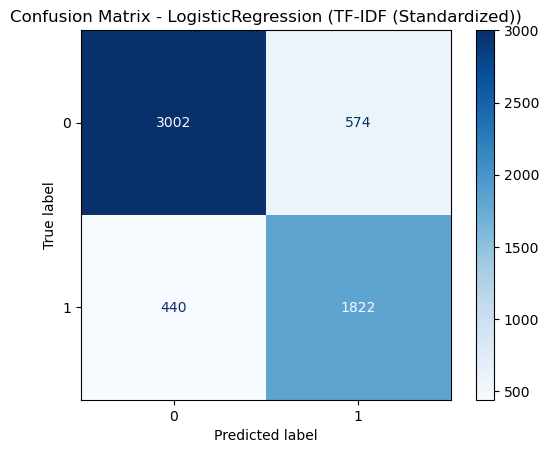

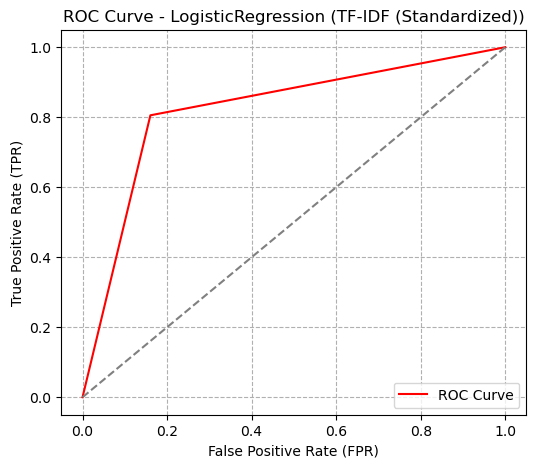

In [317]:
# tune tfidf LR hyperparameters
lr_param_grid = {
    "C": [.4, .45, 0.5, .55, .6],  
    "penalty": ["l2"],  
    "solver": ["saga"]
}

# keep k-best features
k_best = SelectKBest(score_func=chi2, k=4000) 
X_train_tfidf = k_best.fit_transform(X_train_tfidf, y_train_cutoff3)
X_test_tfidf = k_best.transform(X_test_tfidf)

X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff3, test_size=0.2, random_state=42)

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf_sub)
X_val_scaled = scaler.transform(X_val_tfidf)

best_model = tune_model(X_train_scaled, y_train_sub, X_val_scaled, y_val, 
           "TF-IDF (Standardized)", 
           LogisticRegression(max_iter=5000, class_weight="balanced"),
           lr_param_grid)


Best Hyperparameters for HashingVectorizer: {'C': 7, 'penalty': 'l2', 'solver': 'saga'}
Best Macro F1 Score: 0.7553

LogisticRegression (HashingVectorizer) Performance on Validation Set:
Accuracy: 0.8227
Macro F1 Score: 0.7520
ROC AUC: 0.7928500881205606


<Figure size 600x500 with 0 Axes>

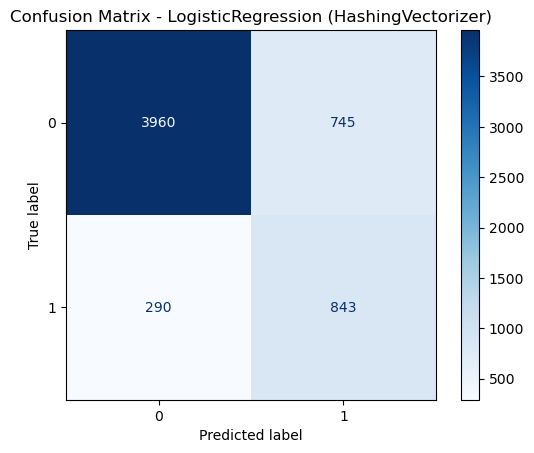

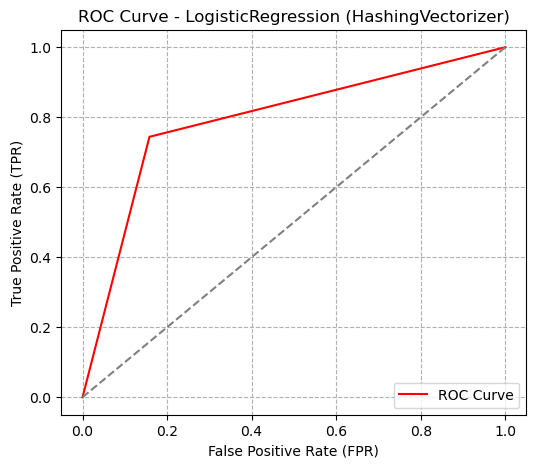

LogisticRegression(C=7, class_weight='balanced', max_iter=5000, solver='saga')

In [367]:
# tune hash LR hyperparameters
lr_param_grid = {
    "C": [2, 5, 6, 7, 8, 9],  
    "penalty": ["l2"],  
    "solver": ["saga"]
}
# # keep k-best features
# k_best = SelectKBest(score_func=chi2, k=4000) 
# X_train_hash = k_best.fit_transform(X_train_hash, y_train_cutoff3)
# X_test_hash = k_best.transform(X_test_hash)

X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff3, test_size=0.2, random_state=42)

tune_model(X_train_hash_sub, y_train_sub, X_val_hash, y_val, 
           "HashingVectorizer", 
           LogisticRegression(max_iter=5000, class_weight="balanced"), 
           lr_param_grid)

#### **SVM**

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i


Best Hyperparameters for TF-IDF (Standardized + Feature Selection): {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
Best Macro F1 Score: 0.7278

SVC (TF-IDF (Standardized + Feature Selection)) Performance on Validation Set:
Accuracy: 0.6984
Macro F1 Score: 0.6964
ROC AUC: 0.7165753564879924


<Figure size 600x500 with 0 Axes>

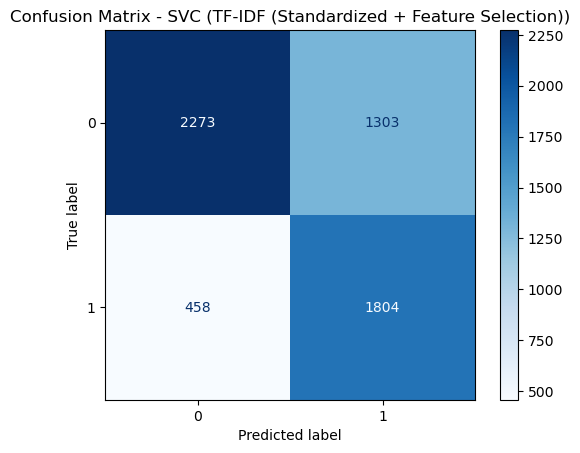

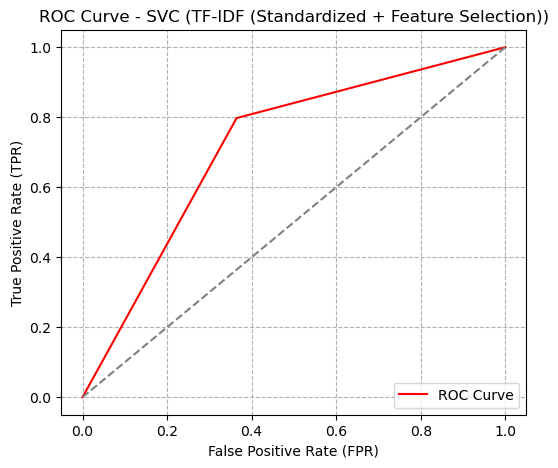

In [325]:
# SVM tdidf
svm_param_grid = {
    "C": [.01, .1, .5, 1, 1.5],  # Regularization strength
    "kernel": ["linear"],  # Linear kernel for text data
    "gamma": ["auto"]
}

k_best = SelectKBest(score_func=chi2, k=4000)

# Apply feature selection to training and validation sets
X_train_tfidf_selected = k_best.fit_transform(X_train_tfidf, y_train_cutoff3)
X_test_tfidf_selected = k_best.transform(X_test_tfidf)

# Split into train and validation sets
X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf_selected, y_train_cutoff3, test_size=0.2, random_state=42)

# Scale data (SVM requires scaling)
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf_sub)
X_val_scaled = scaler.transform(X_val_tfidf)

# Train & tune SVM
best_svm_model = tune_model(X_train_scaled, y_train_sub, X_val_scaled, y_val, 
                            "TF-IDF (Standardized + Feature Selection)", 
                            SVC(max_iter=2000),
                            svm_param_grid)


322112.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
322112.98s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
322112.98s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
322113.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
322113.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
322113.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
322113.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
322113.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debuggi


Best Hyperparameters for HashingVectorizer (Standardized): {'C': 1.5, 'gamma': 'auto', 'kernel': 'linear'}
Best Macro F1 Score: 0.6412

SVC (HashingVectorizer (Standardized)) Performance on Validation Set:
Accuracy: 0.6593
Macro F1 Score: 0.6549
ROC AUC: 0.6676394798212665


<Figure size 600x500 with 0 Axes>

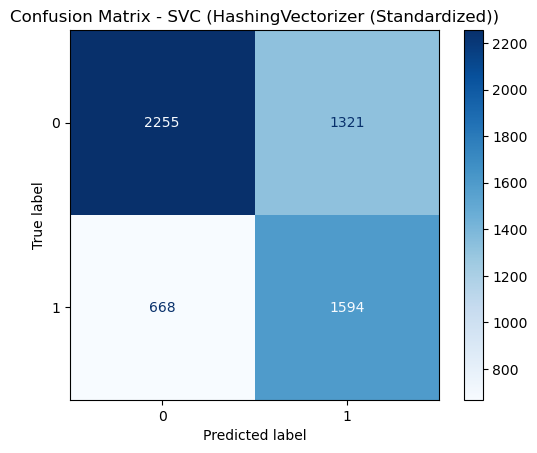

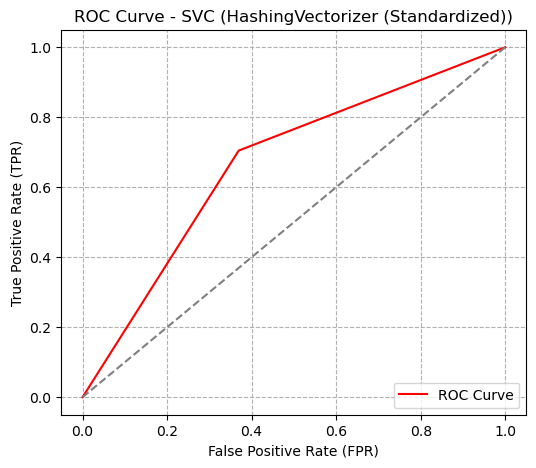

SVC(C=1.5, gamma='auto', kernel='linear', max_iter=1000)

In [326]:
# SVM Hashing Vectorizer
k_best = SelectKBest(score_func=chi2, k=4000)

# Apply feature selection to training and validation sets
X_train_hash_selected = k_best.fit_transform(X_train_hash, y_train_cutoff3)
X_test_hash_selected = k_best.transform(X_test_hash)

X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash_selected, y_train_cutoff3, test_size=0.2, random_state=42)

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_hash_sub)
X_val_scaled = scaler.transform(X_val_hash)

# Train & Tune SVM with Scaled Features
tune_model(X_train_scaled, y_train_sub, X_val_scaled, y_val, 
           "HashingVectorizer (Standardized)", 
           SVC(max_iter=1000),
           svm_param_grid)

#### **Naive Bayes**


Best Hyperparameters for TF-IDF: {'alpha': 0.05}
Best Macro F1 Score: 0.7698

MultinomialNB (TF-IDF) Performance on Validation Set:
Accuracy: 0.7991
Macro F1 Score: 0.7710
ROC AUC: 0.7586663076567033


<Figure size 600x500 with 0 Axes>

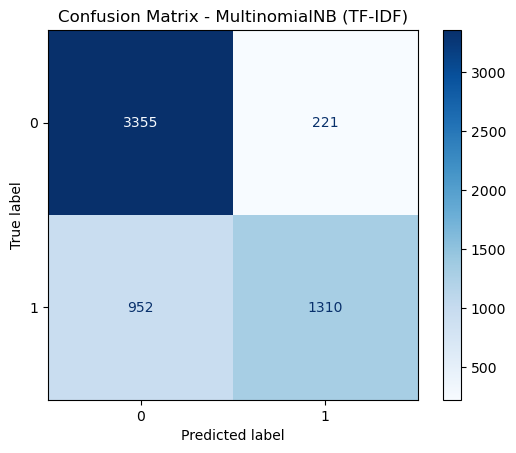

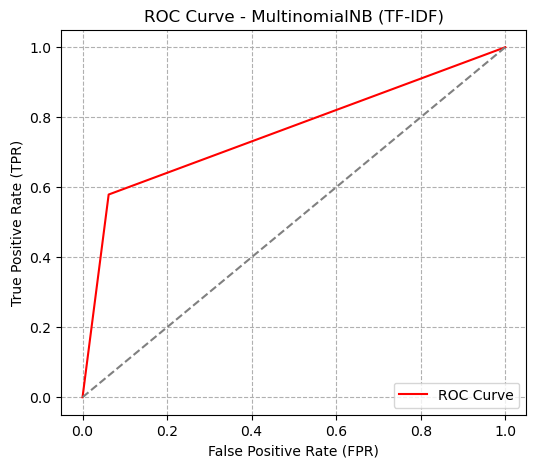

MultinomialNB(alpha=0.05)

In [333]:
# evaluate Naive Bayes tfidf 
NB_param_grid = {
    "alpha": [0.05, 0.1, 0.15, 0.3, 0.5]
}

X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff3, test_size=0.2, random_state=42)

tune_model(X_train_tfidf_sub, y_train_sub, X_val_tfidf, y_val, 
           "TF-IDF", 
           MultinomialNB(), 
           NB_param_grid)


Best Hyperparameters for HashingVectorizer: {'alpha': 0.05}
Best Macro F1 Score: 0.6931

MultinomialNB (HashingVectorizer) Performance on Validation Set:
Accuracy: 0.7568
Macro F1 Score: 0.7041
ROC AUC: 0.6971647113975279


<Figure size 600x500 with 0 Axes>

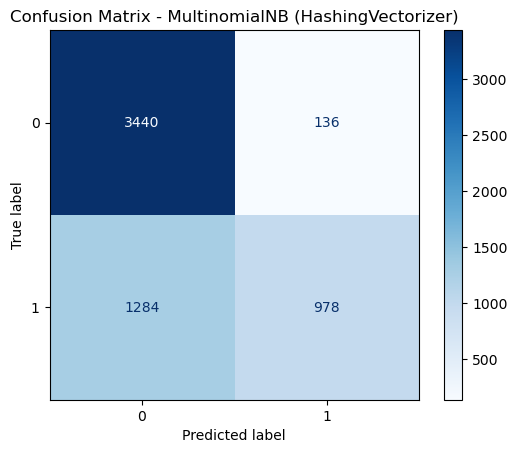

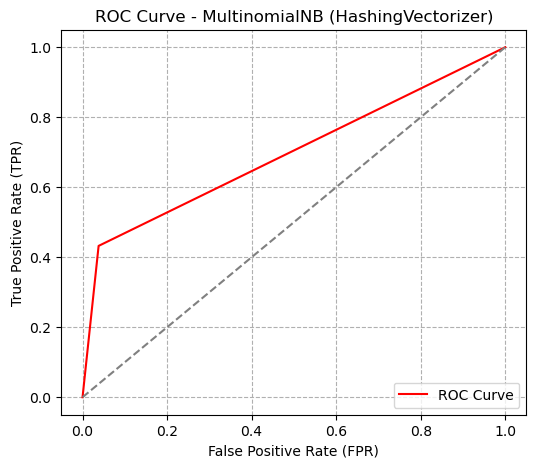

MultinomialNB(alpha=0.05)

In [328]:
# evaluate Naive Bayes hashing
# Use non-negative HashingVectorizer
hash_false = HashingVectorizer(n_features=2**16, alternate_sign=False)
X_train_hash = hash_false.transform(train_df["reviewText"])
X_test_hash = hash_false.transform(test_df["reviewText"])

X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff3, test_size=0.2, random_state=42)

tune_model(X_train_hash_sub, y_train_sub, X_val_hash, y_val, 
           "HashingVectorizer", 
           MultinomialNB(), 
           NB_param_grid)

##### Cutoff 3 best model: Logistic Regression (tdidf)

Save as csv to run on test dataset in kaggle:

In [314]:
# Transform test reviews using the best-performing feature extraction method
# X_test_tfidf = tfidf.transform(test_df["reviewText"])  # LR tfidf was the best
# X_test_tfidf = k_best.transform(X_test_tfidf)

# Use the trained model to predict
y_pred_tfidf = best_model.predict(X_test_tfidf)

# Format predictions for submission
test_ids = test_df.index
test_submission = pd.DataFrame({'id': test_ids, 'binary_split_3': y_pred_tfidf})
print(test_submission.shape) # should be (4500, 2)
test_submission.head()

# # Save the predictions file
test_submission.to_csv("test_submission_part_3.csv", index=False)

print("Submission file saved: test_submission_part_3.csv")

(4500, 2)
Submission file saved: test_submission_part_3.csv


Cutoff = 3 Macro F1 score on test set in Kaggle: **0.80158**

### **Cutoff = 4**

In [339]:
train_df["label_cutoff_4"] = train_df["overall"].apply(lambda x: assign_label(x, cutoff=4))
train_df.head() # inspect
y_train_cutoff4 = train_df["label_cutoff_4"]

#### **Logistic Regression**


Best Hyperparameters for TF-IDF (Standardized): {'C': 0.4, 'penalty': 'l2', 'solver': 'saga'}
Best Macro F1 Score: 0.7527

LogisticRegression (TF-IDF (Standardized)) Performance on Validation Set:
Accuracy: 0.8155
Macro F1 Score: 0.7501
ROC AUC: 0.8031283502461655


<Figure size 600x500 with 0 Axes>

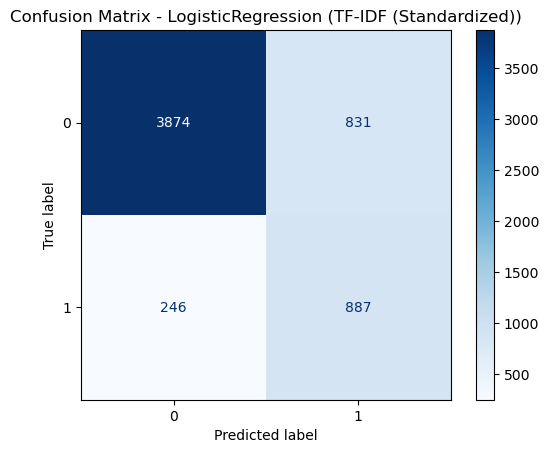

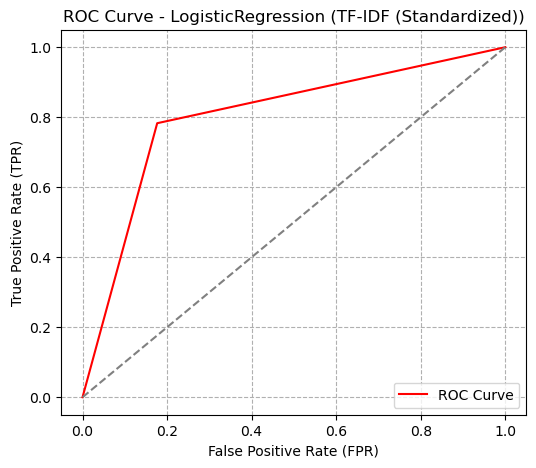


Best Hyperparameters for HashingVectorizer: {'C': 5, 'penalty': 'l2', 'solver': 'saga'}
Best Macro F1 Score: 0.7536

LogisticRegression (HashingVectorizer) Performance on Validation Set:
Accuracy: 0.8227
Macro F1 Score: 0.7535
ROC AUC: 0.7968705242118157


<Figure size 600x500 with 0 Axes>

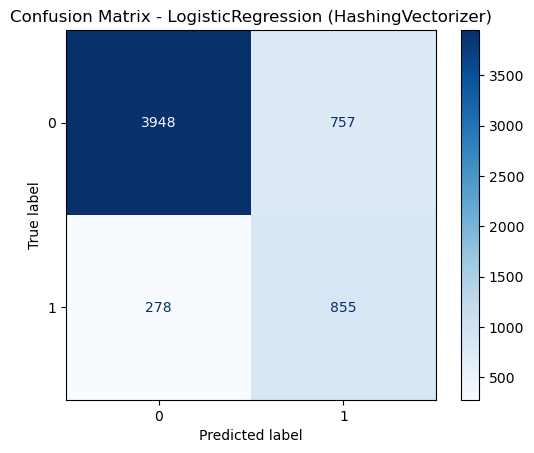

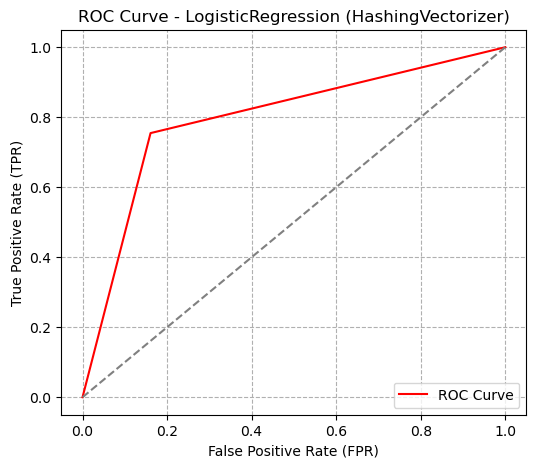

In [352]:
# tune tfidf LR hyperparameters
lr_param_grid = {
    "C": [0.1, 0.25, .4, 0.5, .6, .75, 1, 2, 5],  
    "penalty": ["l2"],  
    "solver": ["saga"]
}

X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff4, test_size=0.2, random_state=42)

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf_sub)
X_val_scaled = scaler.transform(X_val_tfidf)

tune_model(X_train_scaled, y_train_sub, X_val_scaled, y_val, 
           "TF-IDF (Standardized)", 
           LogisticRegression(max_iter=5000, class_weight="balanced"),
           lr_param_grid)


# tune hash LR hyperparameters
lr_param_grid = {
    "C": [3, 4, 4.5, 5, 5.5, 6],  
    "penalty": ["l2"],  
    "solver": ["saga"]
}

X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff4, test_size=0.2, random_state=42)

best_model = tune_model(X_train_hash_sub, y_train_sub, X_val_hash, y_val, 
           "HashingVectorizer", 
           LogisticRegression(max_iter=5000, class_weight="balanced"), 
           lr_param_grid)

#### **SVM**

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i


Best Hyperparameters for TF-IDF (Standardized): {'C': 1.5, 'gamma': 'auto', 'kernel': 'linear'}
Best Macro F1 Score: 0.6274

SVC (TF-IDF (Standardized)) Performance on Validation Set:
Accuracy: 0.6985
Macro F1 Score: 0.6234
ROC AUC: 0.679620467231251


<Figure size 600x500 with 0 Axes>

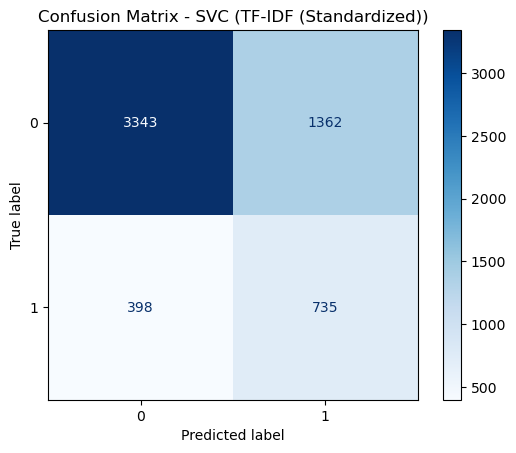

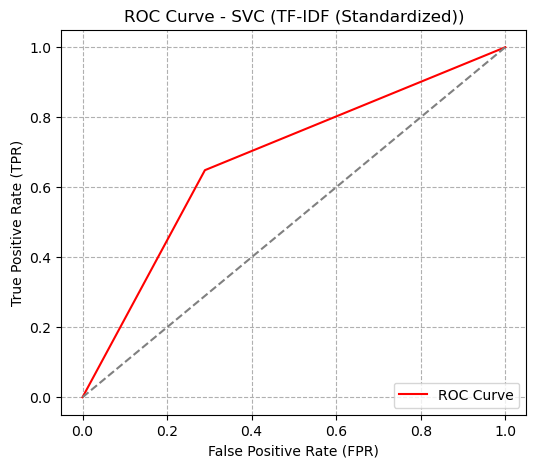

SVC(C=1.5, gamma='auto', kernel='linear', max_iter=1000)

In [342]:
# SVM tdidf
svm_param_grid = {
    "C": [.1, 1, 1.5, 2, 2.5],  # Regularization strength
    "kernel": ["linear"],  # Linear kernel for text data
    "gamma": ["auto"]
}

k_best = SelectKBest(score_func=chi2, k=4000)

# Apply feature selection to training and validation sets
X_train_tfidf_selected = k_best.fit_transform(X_train_tfidf, y_train_cutoff4)
X_test_tfidf_selected = k_best.transform(X_test_tfidf)

X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff4, test_size=0.2, random_state=42)

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf_sub)
X_val_scaled = scaler.transform(X_val_tfidf)

tune_model(X_train_scaled, y_train_sub, X_val_scaled, y_val, 
           "TF-IDF (Standardized)", 
           SVC(max_iter=1000),
           svm_param_grid)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i


Best Hyperparameters for HashingVectorizer (Standardized): {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
Best Macro F1 Score: 0.6412

SVC (HashingVectorizer (Standardized)) Performance on Validation Set:
Accuracy: 0.6430
Macro F1 Score: 0.6289
ROC AUC: 0.6284494558879433


<Figure size 600x500 with 0 Axes>

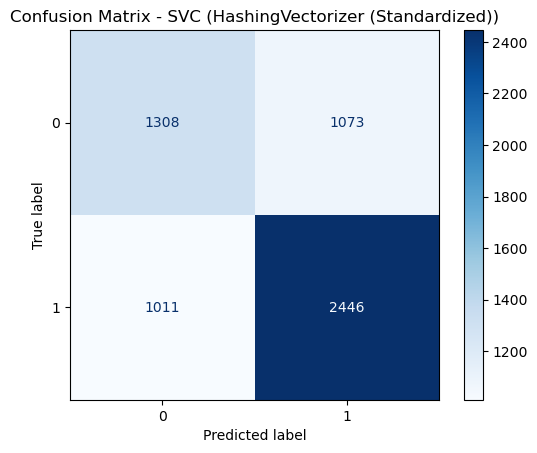

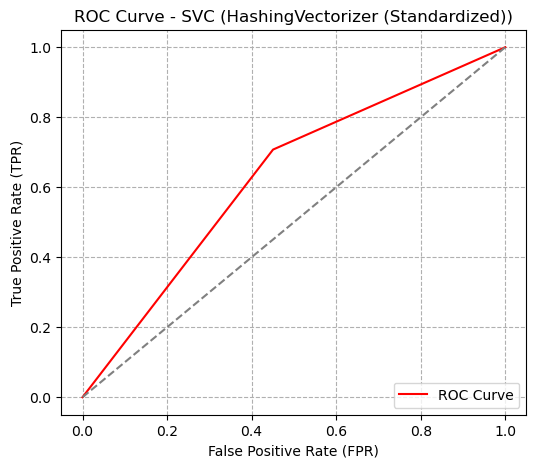

SVC(C=1, gamma='auto', kernel='linear', max_iter=1000)

In [343]:
# SVM HashingVectorizer
X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff4, test_size=0.2, random_state=42)

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_hash_sub)
X_val_scaled = scaler.transform(X_val_hash)

# Train & Tune SVM with Scaled Features
tune_model(X_train_scaled, y_train_sub, X_val_scaled, y_val, 
           "HashingVectorizer (Standardized)", 
           SVC(max_iter=1000),
           svm_param_grid)

#### **Naive Bayes**


Best Hyperparameters for TF-IDF: {'alpha': 0.01}
Best Macro F1 Score: 0.5802

MultinomialNB (TF-IDF) Performance on Validation Set:
Accuracy: 0.8219
Macro F1 Score: 0.5616
ROC AUC: 0.5601385542225178


<Figure size 600x500 with 0 Axes>

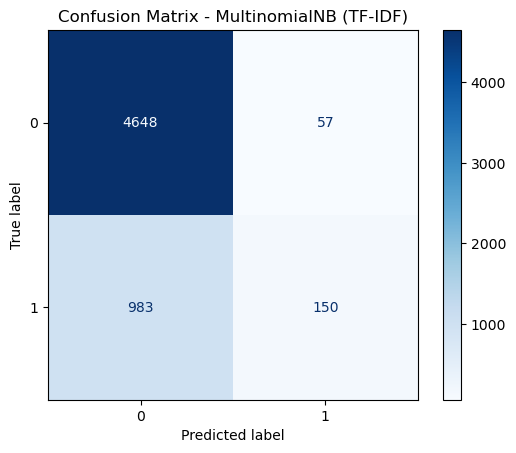

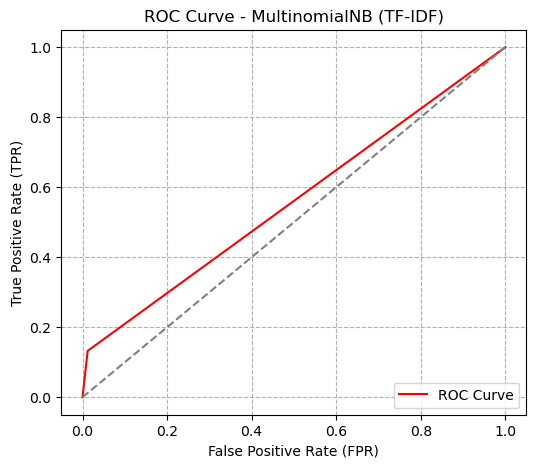


Best Hyperparameters for HashingVectorizer: {'alpha': 0.01}
Best Macro F1 Score: 0.5448

MultinomialNB (HashingVectorizer) Performance on Validation Set:
Accuracy: 0.8153
Macro F1 Score: 0.5251
ROC AUC: 0.5386784073205254


<Figure size 600x500 with 0 Axes>

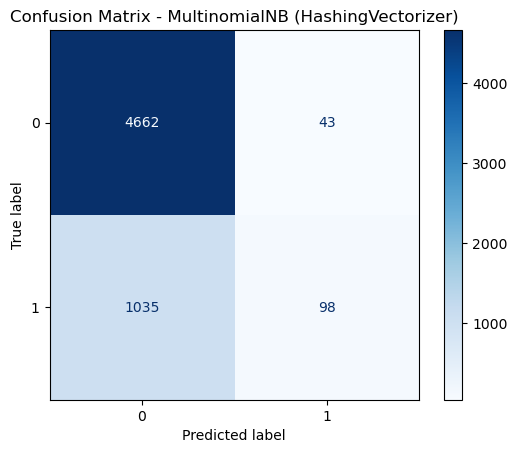

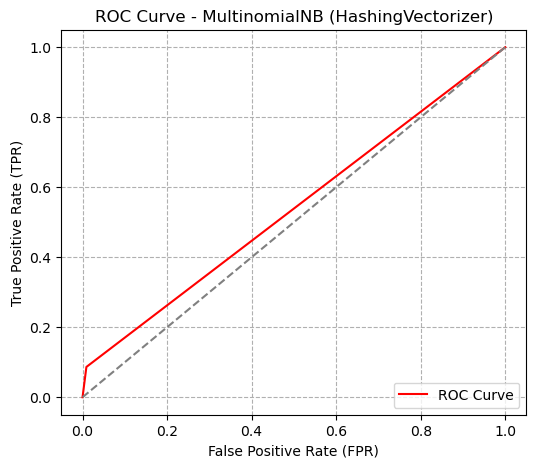

MultinomialNB(alpha=0.01)

In [383]:
# evaluate Naive Bayes tfidf 
NB_param_grid = {
    "alpha": [0.01, 0.05, .1, 0.5, 1]
}

X_train_tfidf_sub, X_val_tfidf, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_cutoff4, test_size=0.2, random_state=42)

tune_model(X_train_tfidf_sub, y_train_sub, X_val_tfidf, y_val, 
           "TF-IDF", 
           MultinomialNB(), 
           NB_param_grid)


# evaluate Naive Bayes hashing
# Use non-negative HashingVectorizer
hash_false = HashingVectorizer(n_features=2**16, alternate_sign=False)
X_train_hash = hash_false.transform(train_df["reviewText"])
X_test_hash = hash_false.transform(test_df["reviewText"])

X_train_hash_sub, X_val_hash, y_train_sub, y_val = train_test_split(
    X_train_hash, y_train_cutoff4, test_size=0.2, random_state=42)

tune_model(X_train_hash_sub, y_train_sub, X_val_hash, y_val, 
           "HashingVectorizer", 
           MultinomialNB(), 
           NB_param_grid)

##### Cutoff 4 best model: Logistic Regression (HashingVectorizer)

Save as csv to run on test dataset in kaggle:

In [354]:
# Transform test reviews using the best-performing feature extraction method
X_test_hash = hash_vectorizer.transform(test_df["reviewText"])  # LR HashingVectorizer was the best
y_pred_hash = best_model.predict(X_test_hash)

# Format predictions for submission
test_ids = test_df.index
test_submission = pd.DataFrame({'id': test_ids, 'binary_split_4': y_pred_hash})
print(test_submission.shape) # should be (4500, 2)
test_submission.head()

# Save the predictions file
test_submission.to_csv("test_submission_part_4.csv", index=False)
print("Submission file saved: test_submission_part_4.csv")

(4500, 2)
Submission file saved: test_submission_part_4.csv


Cutoff = 4 Macro F1 score on test set in Kaggle: **0.74256**

## **Part 2:** Mutliclass Classification

In [61]:
# Ensure target variable contains five-class labels (1-5)
y_train_multiclass = train_df["overall"]

tfidf = TfidfVectorizer(min_df=18, max_df=.5, sublinear_tf=True, use_idf=True, ngram_range=(1, 2))

X_train_tfidf = tfidf.fit_transform(train_df['reviewText'])

### Ensure functions to evaluate and tune model supports multiclass

In [62]:
def evaluate_model(y_true, model, X_val, model_name):
    # Get predictions
    y_pred = model.predict(X_val)
    
    # Check if the model supports probability prediction
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_val)  # Use probability estimates for AUC
    else:
        y_pred_proba = None  # Some models (e.g., SVM with "linear" kernel) do not support probabilities

    # Compute metrics
    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    macro_f1 = metrics.f1_score(y_true, y_pred, average="macro")

    # Determine if it's a multiclass problem
    is_multiclass = len(set(y_true)) > 2

    # Compute ROC AUC Score correctly
    if is_multiclass and y_pred_proba is not None:
        roc_auc = metrics.roc_auc_score(y_true, y_pred_proba, average="macro", multi_class="ovo")
    else:
        roc_auc = metrics.roc_auc_score(y_true, y_pred) if not is_multiclass else "N/A"

    print(f"\n{model_name} Performance on Validation Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"ROC AUC: {roc_auc}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    metrics.ConfusionMatrixDisplay(conf_matrix).plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Plot ROC Curve
    if is_multiclass and y_pred_proba is not None:
        # Binarize the labels for multi-class ROC curve
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

        plt.figure(figsize=(8, 6))
        for i in range(y_true_bin.shape[1]):  # Loop over each class
            fpr, tpr, _ = metrics.roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
            plt.plot(fpr, tpr, label=f"Class {i+1}")

        # Random baseline
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title(f"Multiclass ROC Curve - {model_name}")
        plt.legend(loc="lower right")
        plt.grid(linestyle="--")
        plt.show()

    elif not is_multiclass:
        fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color="red", label="ROC Curve")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random chance line
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc="lower right")
        plt.grid(linestyle="--")
        plt.show()


In [63]:
def tune_model(X_train, y_train, X_val, y_val, vectorizer_name, model, param_grid):
    # Define scoring metrics
    scoring = {
        "AUC": "roc_auc_ovr",  # Supports multiclass ROC AUC
        "Accuracy": make_scorer(accuracy_score),
        "Macro F1": make_scorer(f1_score, average="macro")
    }

    # Perform 5-fold cross-validation
    gs = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring=scoring,
        refit="Macro F1",  # Choose the best model based on F1 score
        n_jobs=-1,
        cv=5,  # Ensures 5-fold CV
        return_train_score=True,
    )

    gs.fit(X_train, y_train)
    
    # Extract best model and hyperparameters
    best_model = gs.best_estimator_
    best_model.fit(X_train, y_train)  # Fit on the full training data

    # Evaluate on validation set
    evaluate_model(y_val, best_model, X_val, f"{model.__class__.__name__} ({vectorizer_name})")

    print(f"\nBest Hyperparameters for {vectorizer_name}: {gs.best_params_}")

    return best_model

#### **Logistic Regression**


LogisticRegression (TF-IDF (Multiclass)) Performance on Validation Set:
Accuracy: 0.4877
Macro F1 Score: 0.4818
ROC AUC: 0.7975108841955744


<Figure size 600x500 with 0 Axes>

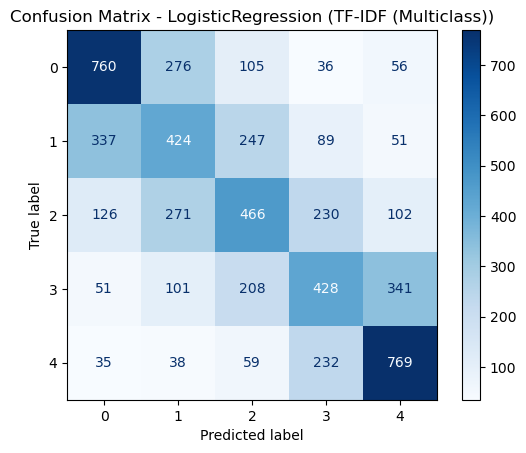

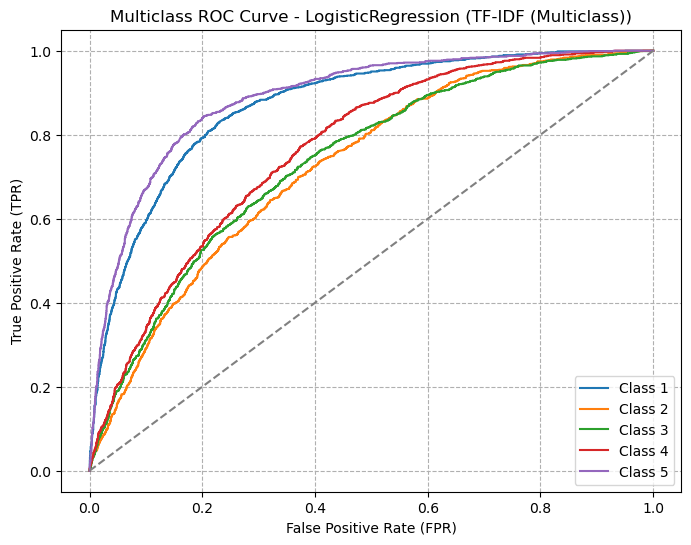


Best Hyperparameters for TF-IDF (Multiclass): {'C': 0.45, 'penalty': 'l2', 'solver': 'saga'}


In [68]:
# Define hyperparameter grid for multiclass LR
lr_param_grid = {
    "C": [.1, .4, .45, .47, .5, 1],  
    "penalty": ["l2"],  
    "solver": ["saga"]
}

# Split into training and validation sets (no feature selection)
X_train_sub, X_val_sub, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_multiclass, test_size=0.2, random_state=42
)

# Apply feature selection
k_best = SelectKBest(score_func=chi2, k=7000)
X_train_tfidf_selected = k_best.fit_transform(X_train_sub, y_train_sub)
X_val_tfidf_selected = k_best.transform(X_val_sub)

# Scale the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf_selected)
X_val_scaled = scaler.transform(X_val_tfidf_selected)

# Train and tune Logistic Regression with 5-fold cross-validation
best_model_mc = tune_model(X_train_scaled, y_train_sub, X_val_scaled, y_val, 
                           "TF-IDF (Multiclass)", 
                           LogisticRegression(max_iter=10000, multi_class='ovr'),
                           lr_param_grid)


#### **SVM**

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i


SVC (TF-IDF (Multiclass)) Performance on Validation Set:
Accuracy: 0.4570
Macro F1 Score: 0.4544
ROC AUC: N/A


<Figure size 600x500 with 0 Axes>

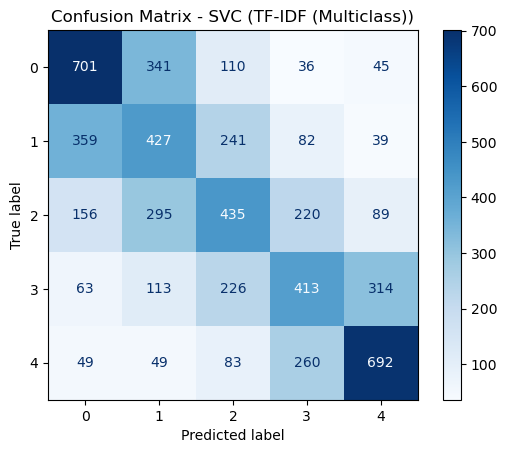


Best Hyperparameters for TF-IDF (Multiclass): {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}


SVC(C=1, gamma='auto', kernel='linear', max_iter=5000)

In [75]:
# Define hyperparameter grid for SVM
svm_param_grid = {
    "C": [1],  
    "kernel": ["linear"],  
    "gamma": ["auto"]
}

# Train and tune SVM
tune_model(X_train_scaled, y_train_sub, X_val_scaled, y_val, 
           "TF-IDF (Multiclass)", 
           SVC(max_iter=5000, decision_function_shape="ovr"),
           svm_param_grid)

#### **Naive Bayes**


MultinomialNB (TF-IDF (Multiclass)) Performance on Validation Set:
Accuracy: 0.4678
Macro F1 Score: 0.4659
ROC AUC: 0.7848165907201242


<Figure size 600x500 with 0 Axes>

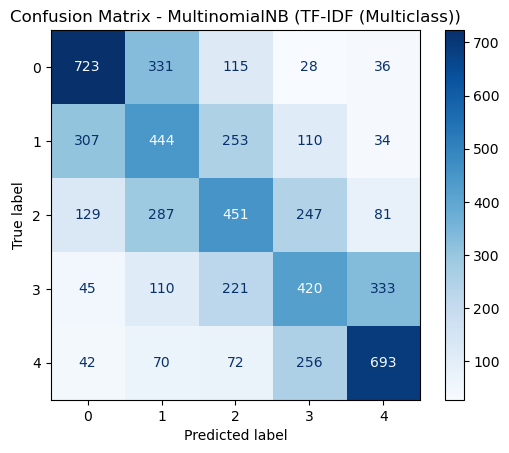

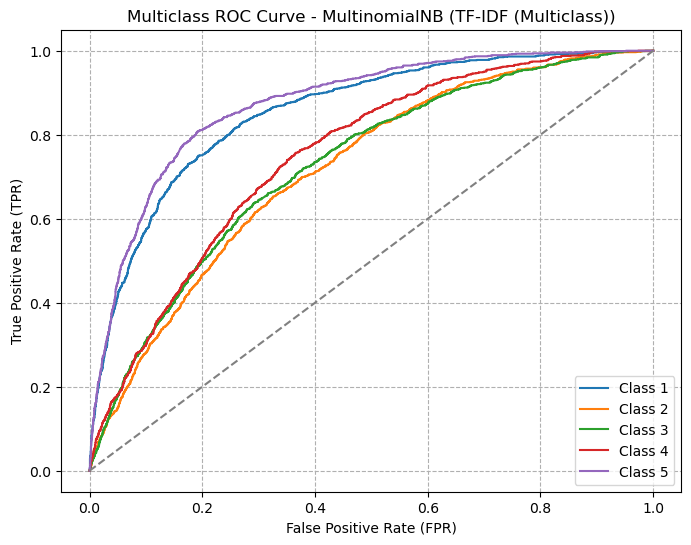


Best Hyperparameters for TF-IDF (Multiclass): {'alpha': 0.1}


MultinomialNB(alpha=0.1)

In [74]:
# Define hyperparameter grid for Naive Bayes
nb_param_grid = {
    "alpha": [0.005, 0.05, 0.1, 0.5, 1, 2]
}

# Split into training and validation sets (no feature selection)
X_train_sub, X_val_sub, y_train_sub, y_val = train_test_split(
    X_train_tfidf, y_train_multiclass, test_size=0.2, random_state=42
)

# Apply feature selection
k_best = SelectKBest(score_func=chi2, k=7000)
X_train_tfidf_selected = k_best.fit_transform(X_train_sub, y_train_sub)
X_val_tfidf_selected = k_best.transform(X_val_sub)

# Scale the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf_selected)
X_val_scaled = scaler.transform(X_val_tfidf_selected)

# Train and tune Logistic Regression with 5-fold cross-validation
tune_model(X_train_scaled, y_train_sub, X_val_scaled, y_val, 
           "TF-IDF (Multiclass)", 
           MultinomialNB(), 
           nb_param_grid)

#### Best model for multiclass classification: 
Save as csv to run on test dataset in kaggle:

In [71]:
# Transform test reviews using the best-performing feature extraction method
X_test = tfidf.transform(test_df["reviewText"])
X_test = k_best.transform(X_test)
X_test = scaler.transform(X_test)
y_pred = best_model_mc.predict(X_test)

# Format predictions for submission
test_ids = test_df.index
test_submission = pd.DataFrame({'id': test_ids, 'label': y_pred})
print(test_submission.shape) # should be (4500, 2)

# Save the predictions file
test_submission.to_csv("test_submission_part_5.csv", index=False)
print("Submission file saved: test_submission_part_5.csv")


(4500, 2)
Submission file saved: test_submission_part_5.csv


Kaggle test set F1 score: **.47329**

## **Part 3:** Clustering

In [741]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import SpectralClustering

tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=True, 
    max_df=0.25,   # Remove very frequent words
    min_df=15,    # Remove rare words (appearing in <10 reviews)
    ngram_range=(1, 2),  # Include bigrams for better context
    stop_words="english"
)

X_test_tfidf = tfidf_vectorizer.fit_transform(test_df["reviewText"])

### K-Means with Reduced Dimensionality

In [730]:
# Reduce Dimensionality with SVD
svd = TruncatedSVD(n_components=6, random_state=42)
X_test_tfidf_reduced = svd.fit_transform(X_test_tfidf)

# Find the Best k (Number of Clusters)
best_silhouette = -1
best_k = None

for k in range(2, 11):  # Test k=2 to k=10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit(X_test_tfidf_reduced).labels_

    silhouette = silhouette_score(X_test_tfidf_reduced, labels)
    print(f"K={k} → Silhouette Score: {silhouette:.4f}")

    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_k = k

print(f"Best K: {best_k} → Best Silhouette Score: {best_silhouette:.4f}")

# Train Final K-Means Model with Best k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
test_df["cluster"] = kmeans.fit_predict(X_test_tfidf_reduced)

# Evaluate Clustering Performance
final_silhouette = silhouette_score(X_test_tfidf_reduced, test_df["cluster"])
sse = kmeans.inertia_  # Sum of Squared Errors (SSE)

print(f"Final K-Means Silhouette Score: {final_silhouette:.4f}")
print(f"Final K-Means SSE: {sse:.4f}")

test_df = test_df.reset_index()
test_df[["index", "cluster"]].to_csv("test_kmeans_results.csv", index=False)
print("K-Means clustering results saved: test_kmeans_results.csv")


K=2 → Silhouette Score: 0.6405
K=3 → Silhouette Score: 0.4873
K=4 → Silhouette Score: 0.3830
K=5 → Silhouette Score: 0.4023
K=6 → Silhouette Score: 0.4100
K=7 → Silhouette Score: 0.4301
K=8 → Silhouette Score: 0.2925
K=9 → Silhouette Score: 0.3040
K=10 → Silhouette Score: 0.3118
Best K: 2 → Best Silhouette Score: 0.6405
Final K-Means Silhouette Score: 0.6405
Final K-Means SSE: 188.4532
K-Means clustering results saved: test_kmeans_results.csv


#### Comparing K-Means with Spectral Clustering

In [731]:
# Reduce dimensionality
svd = TruncatedSVD(n_components=25, random_state=42)
X_test_tfidf_reduced = svd.fit_transform(X_test_tfidf)

In [732]:
best_silhouette = -1
best_k = None

# Test different values of k (clusters)
for k in range(2, 10):
    spectral = SpectralClustering(n_clusters=k, affinity="nearest_neighbors", random_state=42)
    labels = spectral.fit_predict(X_test_tfidf_reduced)

    # Compute Silhouette Score
    silhouette = silhouette_score(X_test_tfidf_reduced, labels)
    print(f"k={k} → Silhouette Score: {silhouette:.4f}")

    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_k = k

print(f"Best k: {best_k} → Best Silhouette Score: {best_silhouette:.4f}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=2 → Silhouette Score: 0.5516


/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=3 → Silhouette Score: 0.5341


/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=4 → Silhouette Score: 0.5277


/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=5 → Silhouette Score: 0.5211


/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=6 → Silhouette Score: 0.5152


/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=7 → Silhouette Score: 0.4115


/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=8 → Silhouette Score: 0.0712


/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=9 → Silhouette Score: -0.0990
Best k: 2 → Best Silhouette Score: 0.5516


### K-Means without Reduced Dimensionality
#### Silouette & Rand Score Reports

In [742]:
def perform_clustering(text_data, actual_labels): 
    text_matrix = tfidf.fit_transform(text_data)

    # Determine the Best Number of Clusters (k)
    possible_k_values = range(2, 10) 
    best_k = None
    best_silhouette = -1

    for k in possible_k_values:
        labels = KMeans(n_clusters=k, 
                              max_iter=200,
                                n_init=10).fit(text_matrix).labels_
        silhouette = silhouette_score(metric='euclidean', 
                                                  X=text_matrix, 
                                                  labels=labels,
                                                  random_state=10)
        print(f"K={k} → Silhouette Score: {silhouette:.4f}")
        rand = rand_score(actual_labels, labels)
        print(f"K={k} rand score: {rand:.4f}")

        # Identify the Best k Based on Silhouette Score
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k

    print(f"Best K: {best_k} → Best Silhouette Score: {best_silhouette:.4f}")
    actual_k = len(np.unique(actual_labels))
    print(f"Unique Labels in Data: {np.unique(actual_labels)}")
    print(f"Optimal Clusters (Best k): {best_k}, True Number of Categories: {actual_k}")

    # Train Model with Optimal k
    final_labels = KMeans(init="k-means++", 
                          n_clusters=best_k, 
                          max_iter=10000, 
                          n_init=100, 
                          random_state=10).fit(text_matrix).labels_

    # Evaluate Performance
    final_silhouette = silhouette_score(metric='euclidean', 
                                        X=text_matrix, 
                                        labels=final_labels)
    final_rand = rand_score(actual_labels, final_labels)
    print(f"\nFinal Silhouette Score: {final_silhouette:.4f}")
    print(f"Final Rand Score: {final_rand:.4f}")

In [744]:
text_data = test_df["reviewText"]
actual_labels = test_df["category"]
perform_clustering(text_data, actual_labels)

K=2 → Silhouette Score: 0.0059
K=2 rand score: 0.4910
K=3 → Silhouette Score: 0.0072
K=3 rand score: 0.5090
K=4 → Silhouette Score: 0.0088
K=4 rand score: 0.5287
K=5 → Silhouette Score: 0.0058
K=5 rand score: 0.6266
K=6 → Silhouette Score: 0.0074
K=6 rand score: 0.6716
K=7 → Silhouette Score: 0.0082
K=7 rand score: 0.6888
K=8 → Silhouette Score: 0.0090
K=8 rand score: 0.7078
K=9 → Silhouette Score: 0.0109
K=9 rand score: 0.7182
Best K: 9 → Best Silhouette Score: 0.0109
Unique Labels in Data: ['CDs' 'automotive' 'cell_phones' 'grocery' 'sports' 'toys']
Optimal Clusters (Best k): 9, True Number of Categories: 6

Final Silhouette Score: 0.0110
Final Rand Score: 0.7245


## **Final Report:**
This project focuses on binary classification, multiclass classification, and clustering of Amazon product reviews. The dataset includes text reviews and categorical product labels. The main goals were:
- Binary Classification: Predict whether a review belongs to a positive or negative sentiment based on cutoff level
- Multiclass Classification: Predict the product rating on a five-class scale (1-5).
- Clustering: Group reviews into meaningful product category clusters.

I built three different types of classifiers: Logistic Regression (LR), Support Vector Machines (SVM), and Naïve Bayes (NB) using three different vectorization methods:
- TF-IDF (Term Frequency-Inverse Document Frequency)
- HashingVectorizer
- CountVectorizer

I found that, with the exception of cutoff levels 1 and 4 which scored best with HashingVectorizer, TF-IDF was the best feature extraction method for my model in terms of accuracy scores. This is likely because it weighs words based on their importance in distinguishing between different classes, so frequent but uninformative words (such as "the") are downweighted, while rare but meaningful words (such as "refund") recieve higher weights. In the context of product review classification, this allows the model to focus on opinionated words that define the sentiment of the review. Each model was tuned using GridSearchCV with 5-fold cross-validation, which selects the best combination of hyperparamters iteratively. Additionally, I implemented SelectKBest to select the k most important features from some models, which increased accuracy by a few points for both the validation and test sets (although selecting too low of a k value caused overfitting). I also performed feature scaling on some LR and SVM models using MaxAbsScaler so that feature values were standardized, finding that this increased accuracy by a few points. The selection of the final models were based on Macro F-1, accuracy, and ROC-AUC scores.

### **Binary Classification**
Best Models & Hyperparameters for Binary Classification
- Cutoff = 1: Logistic Regression (HashingVectorizer), C=10, solver='saga'
    - F1 Macro Score: 0.78
    - Accuracy: .81
    - ROC: .81
- Cutoff = 2: Logistic Regression (TF-IDF) C=0.25, solver='saga' 
    - F1 Score: 0.79
    - Accuracy: .79
    - ROC: .79
- Cutoff = 3: Logistic Regression (TF-IDF) C=0.6, solver='saga'
    - F1 = 0.81
    - Accuracy: .83
    - ROC: .83
- Cutoff = 4: Logistic Regression (Hashing) C=5, solver='saga'
    - F1 = 0.80
    - Accuracy: .82
    - ROC: .80

I tested the three feature extraction methods, finding that CountVectorizer was  more computationally expensive without providing better accuracy than the other two. TF-IDF and HashingVectorizer provided fairly similar accuracy and Macro F1 scores. For all four cutoff levels, the best model was Logistic Regression (with HashingVectorizer extraction method for cutoff = 1 and cutoff = 4, and tf-idf for cutoff = 2 and cutoff = 3). For all four cutoff levels, the best model was Logistic Regression, with Naïve Bayes performing second best, usually marginally missing the Kaggle targets, and SVM performing the worst. On the test data, my best model had Macro F1 scores of 0.73, 0.78, 0.80, and 0.74 for the four cutoff levels, respectively.

In terms of hyper-parameter tuning for Logistic Regression models, I used the l2 regulizer, as l1 took much more run-time without providing better accuracy. In order to find the optimal C value for each model, I first initialized the param_grid passed into GridSearchCV to contain a range of values (usually .001, .1, 1, 5, 10), then trained the model and reported metrics, and then fine tuned the param_grid to test more tightly bound values to what was first reported as the optimal C value. C is the inverse of the regularization strength, meaning that a higher value leads to less regularization (a more complex model) that fits the data better (although I also had to be careful of overfitting). I found that the best C parameter changed depending on which feature extraction method had been implemented. With the TFIDF method, the optimal C values were usually in between 0 and 1 (.75 for cutoff=1, .25 for cutoff=2, .6 for cutoff=3, and .4 for cutoff=4), whereas for the HashingVectorizer method the optimal C values were always over 1 (10 for cutoff=1, 4.5 for cutoff=2, 7 for cutoff=3, and 5 for cutoff=4). This is likely because HashingVectorizer doesn't store word frequencies, meaning some features may be weighted smaller due to hash collisions, and a higher C compansates by reducing regularization. TD-IDF, on the other hand, captures word importance, so a lower C helps prevent overfitting. I also found that setting class_weights = "balanced" improved model performance by a few points.

For the SVM models, C controls the soft margin penalty, so a higher C penalizes misclassification more (and thus there is a higher risk of overfitting as C increases). I found that for most models, C was optimal at 1 or 1.5 regardless of feature extraction method. This is likely because a balanecd decision boundary avoids overfitting to noise while simultaneously capturing patterns. I used a linear kernel because this tends to work well for high-dimensional text data, and found that other kernels such as rbf performed poorly and significantly increased training time.

For the Naive Bayes models, I tuned the alpha parameter which is a smoothing parameter. A smaller value leads to less smoothing meaning the model relies on word frequencies heavily and there is a greater risk of overfitting. The optimal alpha for models were usually around 0.05.

### **Multiclass Classification**
Best model & hyperparameters for multiclass:
- Logistic Regression (TF-IDF), C = 0.45, penalty= L2, and solver=Saga 
    - F1 Score: .48
    - Accuracy: .49
    - ROC: .80

For multiclass classification, I extended the models to predict ratings from 1-5. The best-performing model was Logistic Regression with TF-IDF. Naive Bayes also performed well (F1 score .46), followed by SVM (F1 score of .45). The confusion matrix reveals some misclassification, with some overlap between classes, likely due to class imbalances or overlapping feature distributions. The ROC curve indicates that while some classes achieve strong separability, others struggle, particularly in the mid-range FPR. 

Compared to binary classification with different cutoff levels, multinomial classification performed worse. This suggests that certain class distinctions are more effectively captured through binary approaches rather than a direct multinomial framework. The drop in performance may be due to high class overlap in the feature space, increased model complexity leading to difficulties in convergence, and potential feature sparsity issues with TF-IDF when applied to a multiclass setup (although TF-IDF models performed better than HashingVectorizer). 

### **Clustering**
Best Spectral Model Scores:
- Spectral Clustering: k = 2
    - Silouette Score = 0.55

Best K-Means Model Scores:
- With Dimensionality Reduction:
    - k = 2
        - Silouette Score = 0.64
- Without Dimensionality Reduction: 
    - k = 9
        - Silouette Score = .01, Rand score = .72

Clustering was performed on product reviews to group them based on text similarity. The primary goal was to form clusters that aligned with product categories. Performance was measured using silhouette score to measure how well-separated the clusters are as well as rand score to measure how well the clustering matches the true product categories. I implemented two clustering methods, as I wanted to explore how they handled this dataset differently:
- Spectral Clustering (graph-based approach)
    - Spectral Clustering is known to handle high-dimensional text data better than K-Means. 
    - I used TF-IDF feature extraction and SVD (singular value decomposition) for improved separation.
    - The best performance was k = 2, achieving a Silhouette Score of 0.55, suggesting moderate separation but not highly distinct clusters.
- K-Means (centroid-based clustering)
    - I used TF-IDF vectorization with bigram inclusion (ngram_range=(1,2)) to capture contextual meaning.
    - I tested different values of k (from 2 to 10) to find the optimal cluster count, and evaluated each k using silhouette score and rand score.

To explore how dimensionality affects clustering, I applied Truncated SVD (a type of Latent Semantic Analysis (LSA)) to reduce feature dimensionality, revealing a trade-off between silhouette score and rand score. Higher dimensionality (without SVD) produced very low silouette scores (0.01), which suggests poor separation between clusters, meaning that reviews in different clusters are not well-distinguished. However, the high rand score (0.72) indicates that the clusters still aligned well with actual product categories. Reduced dimensionality (SVD) improved silhouette scores but significantly lowered rand scores, suggesting clearer cluster separation but less category alignment. K-Means without SVD is the best model in the practical sense due to its better real-world category alignment. The results indicate that text alone is somewhat effective for clustering products, but further improvements could be made in the future by including additional features (such as rating, verification, image, etc) to improve cluster alignment.

Comparison:
- K-Means outperformed Spectral Clustering in terms of Silhouette Score
- Spectral Clustering resulted in less distinct clusters (Silhouette Score = 0.55), whereas K-Means provided better separation.

### Future Improvements
To expand the scope of the project in the future, I am interested in exploring deep learning models. While traditional machine learning models like Logistic Regression, SVM, and Naïve Bayes performed well, deep learning approaches could further enhance classification by capturing semantic relationships in text. Long Short-Term Memory (a type of RNN) networks are effective for text classificaiton as the capture long-range dependencies, meaning they could handle context-dependent word meaning. CNNs are also known to perform well on text, extracting local n-gram patterns instead of treating text as sequential data. This could be particularly useful for binary sentiment analysis with phrase-based shifts are crucial. I am also interested in alternative vectorization techniques,as TF-IDF still has limitations such as ignoring word order and context. Additionally, incorporating additional metadata (such as review length, helpfulness scores, and verification) could improve improve cluster separation and alignment with real-world product categories.